In [ ]:
# import sympy

In [ ]:
# demo of sympy
from sympy.core.symbol import symbols
from sympy.solvers.solveset import nonlinsolve
x, y = symbols('x, y', real=True)
nonlinsolve([4*x, 2*x*y - 6*y**2 + 2*y], [x, y])

In [ ]:
# first im ignoring death rate and combining the two infection rates
# suseptible, infected, recovered, and dead
s, i, r, d = symbols('s, i, r, d', real=True)
# b is infection rate
# N is total population
# a (alpha) is rate recovered population turns suseptible again
# d1 is the death rate of infected indivual
b, N, a, d1 = symbols('b, N, a, d1', real=True)
nonlinsolve([(-b*s*i)/N, (b*s*i)/N - r*i - d1*i, r*i - a*r, d1*i], [s, i, r, d])

In [89]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [107]:
agency_df = pd.read_csv("https://raw.githubusercontent.com/pfflanders/california-coronavirus-data/master/latimes-state-totals.csv", parse_dates=["date"])
agency_df.head()

,date,confirmed_cases,deaths,new_confirmed_cases,new_deaths
0,2021-09-02,4363257,65596,11920.0,140.0
1,2021-09-01,4351337,65456,16692.0,174.0
2,2021-08-31,4334645,65282,22701.0,77.0
3,2021-08-30,4311944,65205,21070.0,82.0
4,2021-08-29,4290874,65123,3620.0,25.0


In [219]:
N = 40000000 # population of california

b = 0.05 # terrible approximation of rate of covid transmission. 
d1 = 0.0001 # approx death rate of covid
r1 = 0.02 # rate of infected population recovering
a = 0.02 # rate of recovered -> suseptible

steps = 586 # days since start of covid

In [220]:
def sirs(t, z, N, b, d1, r1, a):
    """
    t: time step
    z: Tuple of ints: (s, i, r, d) 
    b: approximate rate of covid transmission
    N: total population of sim
    a: rate of recovered -> suseptible
    d1: death rate of infected individuals
    
    """
    s, i, r, d = z
    return [
        (-b*s*i)/N + a*r,        # ds/dt
        ( b*s*i)/N - r1*i - d1*i, # di/dt
        r1*i - a*r,               # dr/dt
        d1*i                     # d(dead)/dt
    ]

In [221]:
sol = solve_ivp(fun=sirs, 
                t_span=[0, steps],
                y0=[N-100, 1000, 0, 0],
                args=(N, b, d1, r1, a),
                dense_output=True)

In [222]:
t = np.linspace(0, steps, steps)


In [223]:
z = sol.sol(t)


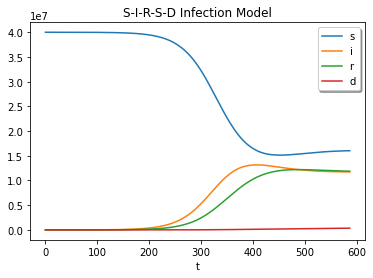

In [224]:
plt.plot(t, z.T)

plt.xlabel('t')
plt.legend(['s', 'i', 'r', 'd'], shadow=True)
#plt.yscale('log')
plt.title('S-I-R-S-D Infection Model')
plt.show()

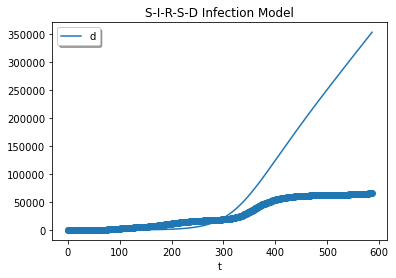

In [225]:
plt.plot(t, z[3].T)
plt.scatter(agency_df['date'].apply(lambda x: x.value/10**9/60/60/24 - 18287.0), agency_df["deaths"])
plt.xlabel('t')
plt.legend(['d'], shadow=True)
#plt.yscale('log')
plt.title('S-I-R-S-D Infection Model')
plt.show()


## Leave the above lines for reference

## Things to do
 1. More complicated model needs to be implemented (this is the biggest, try modifying the above code for reference)
 2. Model needs to be tuned to match data more closely
 3. (2) might be easier done once we have a more complicated model?
 
## Less Important Things
 4. You could write some analysis of what we are doing to help others reading the notebook
 5. Graphs could look nicer (using plotly or seaborn or just nicer colors)